In [11]:
# import cv2 as cv 
import numpy as np 
import matplotlib.pyplot as plt 

- Use all the data to get an initial model approximation 
- remove the outliers 

BUT RANSAC: \
    - uses smallest set of points \
    - increases number of points consistent to the model 

s -> no of points you will choose to fit\
p -> prob of success you want \
e -> proportion outliers? \
   then,  - proportion inliers = 1-e 

N >= (log(1-p))/(log(1-(1-e)^s))
so, N is how many times I need to repeat to get the optimal inliers? 

In [6]:
def getN(p, e, s):
    N = np.log(1-p) / np.log(1-(1-e)**s)
    return np.ceil(N )

In [10]:
getN(0.99, 0.05, 2), getN(0.99, 0.5, 2)

(2.0, 17.0)

C:\Users\OMEN\AppData\Local\Temp\ipykernel_15420\3678480911.py:2: RuntimeWarning: divide by zero encountered in log
  N = np.log(1-p) / np.log(1-(1-e)**s)
C:\Users\OMEN\AppData\Local\Temp\ipykernel_15420\3678480911.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  N = np.log(1-p) / np.log(1-(1-e)**s)


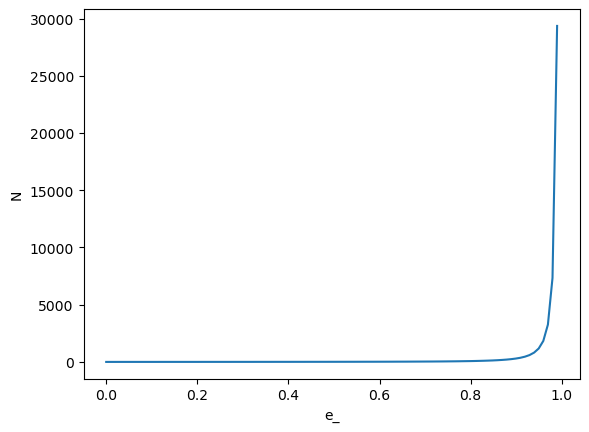

In [13]:
#exploring relation of N with other parameters 

#N and e
p = 0.95
s = 2

e_ = np.linspace(0,1, 100)
N = [getN(p,e,s) for e in e_]

plt.plot(e_, N)
plt.xlabel('e_')
plt.ylabel('N')
plt.show() 

[2 3 4 5 6 7]
[74.0, 373.0, 1871.0, 9361.0, 46807.0, 234041.0]


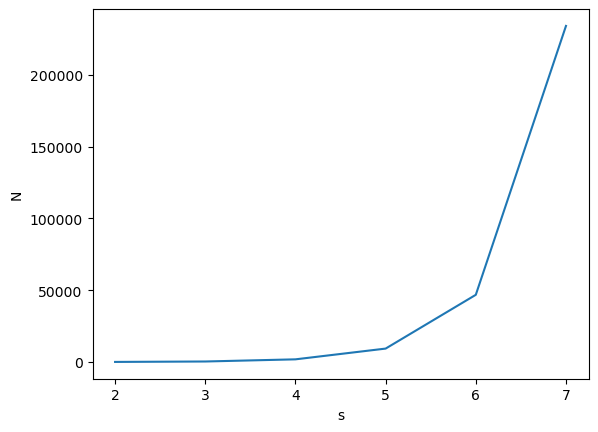

In [21]:
# N and s 
s_ = np.arange(2,8)
print(s_)

p=0.95
e = 0.80

N = [getN(p,e,s) for s in s_]
print(N)
plt.plot(s_, N)
plt.xlabel('s')
plt.ylabel('N')
plt.show()

In [22]:
#y=mx+c, m and c are parameters 
#linear model 
def getY(p, x):
    m,c = p 
    return m*x + c 

In [23]:
#getting the inliers that lie close to the line taken at particular N 
def getInliers(p, data, thres):
    inliers = []
    for point in data: 
        x,y = point 
        y_pred = getY(p, x)
        if(abs(y_pred-y))<thres:
            inliers.append(point)
    return inliers 

(100,) (100,)


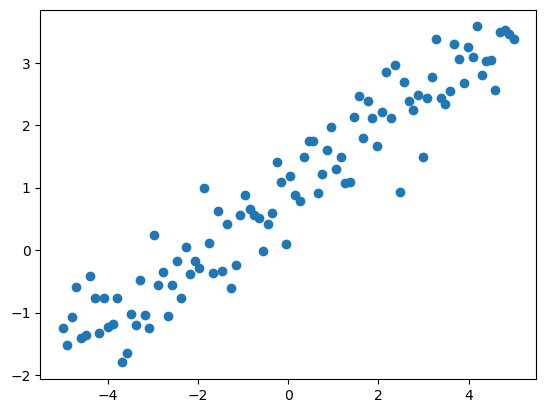

In [30]:
np.random.seed(42)
x = np.linspace(-5, 5, 100)
y = 0.5 * x + 1.0 + np.random.normal(0, 0.5, size=x.size)
print(x.shape, y.shape)
plt.scatter(x, y)

(170,) (170,)


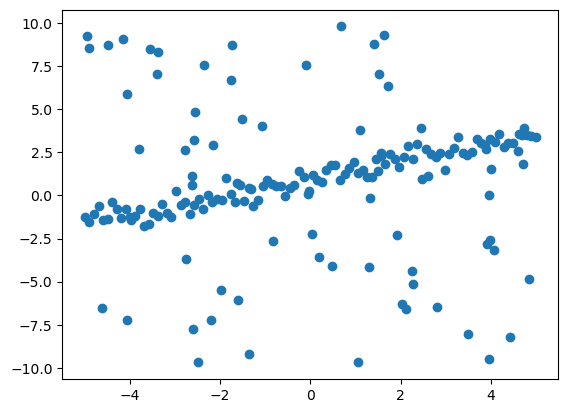

In [32]:
# Add some outliers
n_outliers = 40
x_outliers = np.random.uniform(-5, 5, n_outliers)
y_outliers = np.random.uniform(-10, 10, n_outliers)

x = np.concatenate((x, x_outliers))
y = np.concatenate((y, y_outliers))
print(x.shape, y.shape)
plt.scatter(x, y)

In [36]:
data = np.column_stack((x, y))
data.shape 

(170, 2)

[[-4.15860035  9.07857154]
 [-2.15159506  2.90345581]]


(array([[-4.15860035,  1.        ],
        [-2.15159506,  1.        ]]),
 -3.0767809885028052,
 -3.7165309557617023)

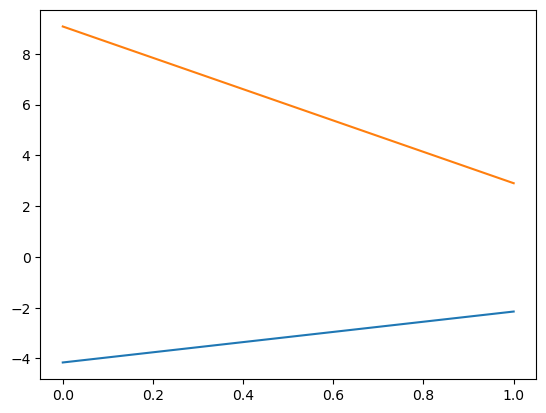

In [44]:
sample = data[np.random.choice(data.shape[0], 2)]
print(sample)
plt.plot (sample)
x_sample, y_sample = sample[:, 0], sample[:, 1]
A = np.vstack([x_sample, np.ones(len(x_sample))]).T
m, b = np.linalg.lstsq(A, y_sample, rcond=None)[0]
A, m, b 

[array([-5.        , -1.25164292]), array([-4.7979798 , -1.07514563]), array([-4.6969697 , -0.58696992]), array([-4.5959596 , -1.41505649]), array([-4.49494949, -1.36454323]), array([-4.39393939, -0.40736329]), array([-4.29292929, -0.76274728]), array([-4.19191919, -1.33069679]), array([-4.09090909, -0.77417452]), array([-3.98989899, -1.22665834]), array([-3.88888889, -1.17730932]), array([-3.78787879, -0.77295826]), array([-3.68686869, -1.80007447]), array([-3.58585859, -1.65538821]), array([-3.48484848, -1.02356801]), array([-3.38383838, -1.19833475]), array([ 3.9711026 , -9.51368067]), array([-3.98528457, -1.43631703]), array([-2.75730691, -3.6615599 ]), array([ 3.4922341 , -8.05647012])]


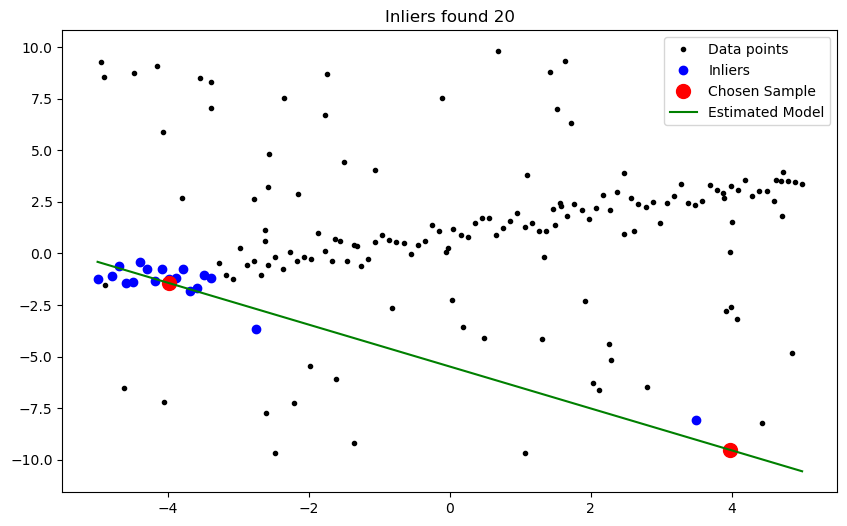

[array([-5.        , -1.25164292]), array([-4.8989899, -1.5186271]), array([-4.7979798 , -1.07514563]), array([-4.6969697 , -0.58696992]), array([-4.5959596 , -1.41505649]), array([-4.49494949, -1.36454323]), array([-4.39393939, -0.40736329]), array([-4.29292929, -0.76274728]), array([-4.19191919, -1.33069679]), array([-4.09090909, -0.77417452]), array([-3.98989899, -1.22665834]), array([-3.88888889, -1.17730932]), array([-3.78787879, -0.77295826]), array([-3.58585859, -1.65538821]), array([-3.48484848, -1.02356801]), array([-3.38383838, -1.19833475]), array([-3.28282828, -0.48429048]), array([-3.18181818, -1.04492113]), array([-3.08080808, -1.24655589]), array([-2.97979798,  0.24292539]), array([-2.87878788, -0.55228209]), array([-2.77777778, -0.35512479]), array([-2.67676768, -1.05075793]), array([-2.57575758, -0.56007015]), array([-2.47474747, -0.18191244]), array([-2.37373737, -0.76236548]), array([-2.27272727,  0.05148537]), array([-2.17171717, -0.38617793]), array([-2.07070707, -

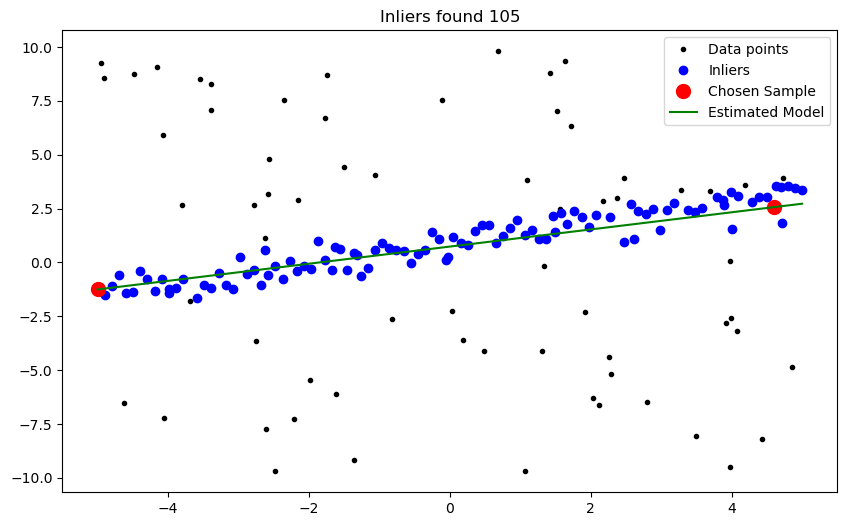

[array([-5.        , -1.25164292]), array([-4.8989899, -1.5186271]), array([-4.7979798 , -1.07514563]), array([-4.6969697 , -0.58696992]), array([-4.5959596 , -1.41505649]), array([-4.49494949, -1.36454323]), array([-4.39393939, -0.40736329]), array([-4.29292929, -0.76274728]), array([-4.19191919, -1.33069679]), array([-4.09090909, -0.77417452]), array([-3.98989899, -1.22665834]), array([-3.88888889, -1.17730932]), array([-3.78787879, -0.77295826]), array([-3.48484848, -1.02356801]), array([-3.28282828, -0.48429048]), array([-2.97979798,  0.24292539]), array([-2.87878788, -0.55228209]), array([-2.77777778, -0.35512479]), array([-2.57575758, -0.56007015]), array([-2.47474747, -0.18191244]), array([-2.27272727,  0.05148537]), array([-2.17171717, -0.38617793]), array([-2.07070707, -0.18120041]), array([-1.96969697, -0.28570179]), array([-1.86868687,  0.99179566]), array([-1.76767677,  0.109413  ]), array([-1.56565657,  0.62844417]), array([-1.36363636,  0.42261362]), array([-1.06060606,  

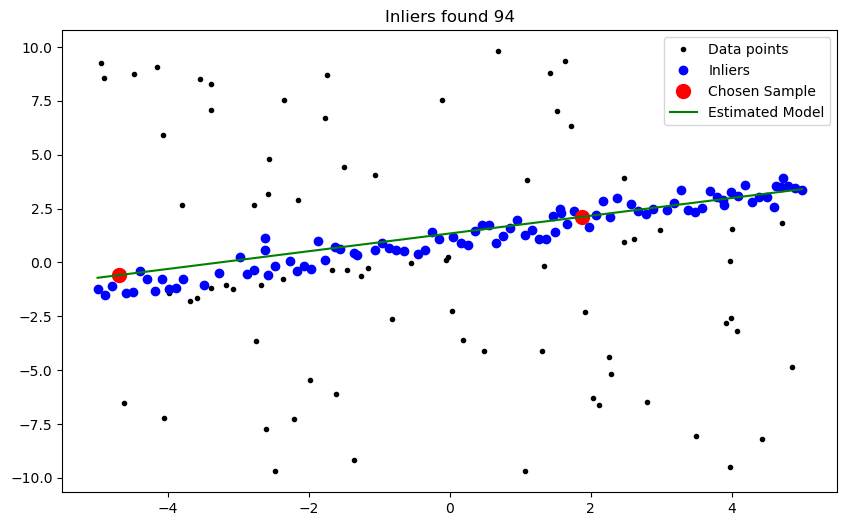

[array([-5.        , -1.25164292]), array([-4.8989899, -1.5186271]), array([-4.7979798 , -1.07514563]), array([-4.6969697 , -0.58696992]), array([-4.5959596 , -1.41505649]), array([-4.49494949, -1.36454323]), array([-4.39393939, -0.40736329]), array([-4.29292929, -0.76274728]), array([-4.19191919, -1.33069679]), array([-4.09090909, -0.77417452]), array([-3.98989899, -1.22665834]), array([-3.88888889, -1.17730932]), array([-3.78787879, -0.77295826]), array([-3.68686869, -1.80007447]), array([-3.58585859, -1.65538821]), array([-3.48484848, -1.02356801]), array([-3.38383838, -1.19833475]), array([-3.28282828, -0.48429048]), array([-3.18181818, -1.04492113]), array([-3.08080808, -1.24655589]), array([-2.87878788, -0.55228209]), array([-2.77777778, -0.35512479]), array([-2.67676768, -1.05075793]), array([-2.57575758, -0.56007015]), array([-2.47474747, -0.18191244]), array([-2.37373737, -0.76236548]), array([-2.17171717, -0.38617793]), array([-2.07070707, -0.18120041]), array([-1.96969697, -

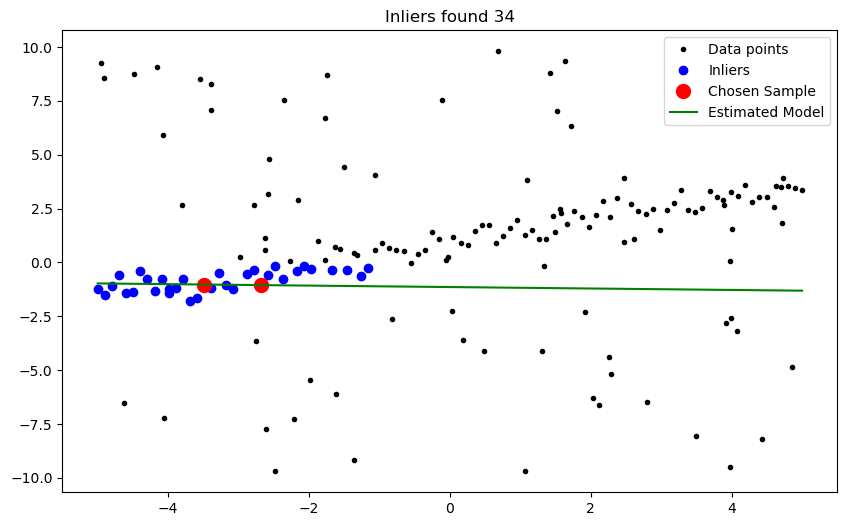

[array([-5.        , -1.25164292]), array([-4.8989899, -1.5186271]), array([-4.7979798 , -1.07514563]), array([-4.6969697 , -0.58696992]), array([-4.5959596 , -1.41505649]), array([-4.49494949, -1.36454323]), array([-4.39393939, -0.40736329]), array([-4.29292929, -0.76274728]), array([-4.19191919, -1.33069679]), array([-4.09090909, -0.77417452]), array([-3.98989899, -1.22665834]), array([-3.88888889, -1.17730932]), array([-3.78787879, -0.77295826]), array([-3.68686869, -1.80007447]), array([-3.58585859, -1.65538821]), array([-3.48484848, -1.02356801]), array([-3.38383838, -1.19833475]), array([-3.28282828, -0.48429048]), array([-3.18181818, -1.04492113]), array([-3.08080808, -1.24655589]), array([-2.87878788, -0.55228209]), array([-2.77777778, -0.35512479]), array([-2.67676768, -1.05075793]), array([-2.57575758, -0.56007015]), array([-2.47474747, -0.18191244]), array([-2.37373737, -0.76236548]), array([-2.27272727,  0.05148537]), array([-2.17171717, -0.38617793]), array([-2.07070707, -

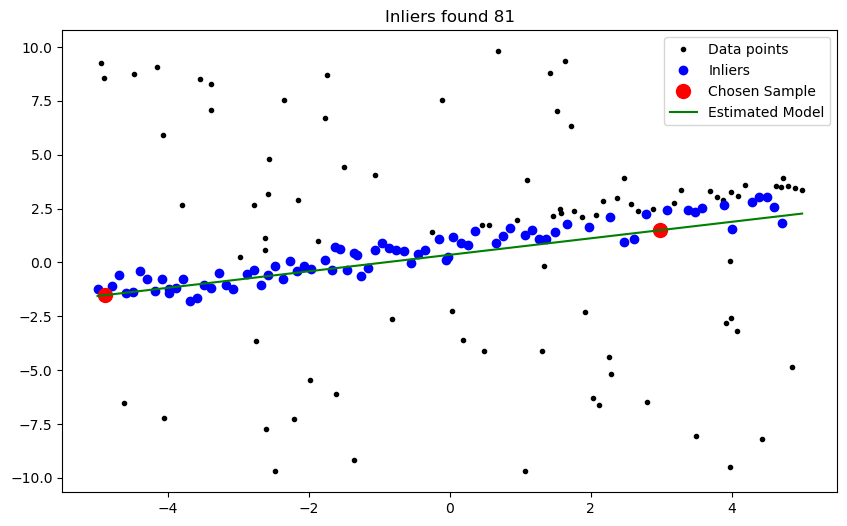

[array([2.37373737, 2.96919051]), array([2.61619615, 1.10401623]), array([ 3.4922341 , -8.05647012])]


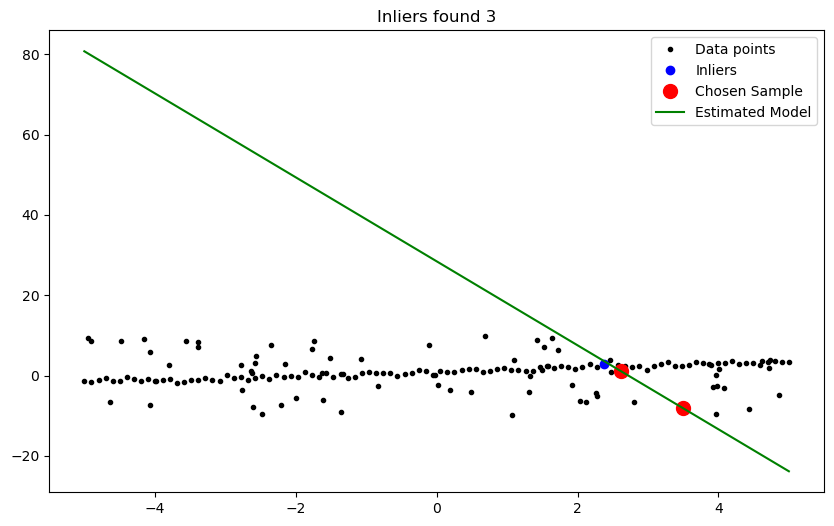

[array([2.97979798, 1.49611453]), array([3.08080808, 2.4305681 ]), array([3.18181818, 2.76946538]), array([3.38383838, 2.43278408]), array([3.48484848, 2.33817744]), array([3.58585859, 2.54205077]), array([3.68686869, 3.3011354 ]), array([3.78787879, 3.05831495]), array([ 1.91895198, -2.29804543]), array([ 1.31138626, -4.12816311])]


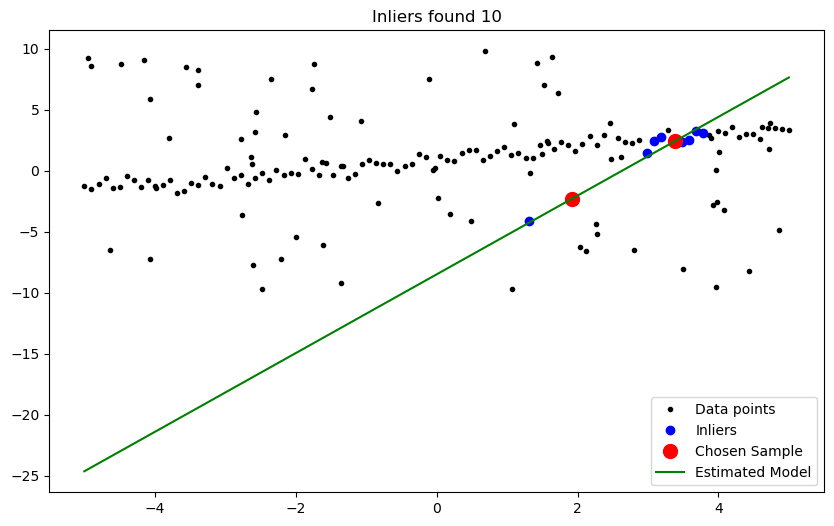

[array([ 2.03018959, -6.26962979]), array([-4.63113053, -6.51267142]), array([-2.21353536, -7.24958112]), array([-2.60438109, -7.73052958]), array([-1.60970209, -6.09514024]), array([ 2.79875546, -6.45778641]), array([ 2.12179221, -6.61014507]), array([-4.06325232, -7.1983197 ])]


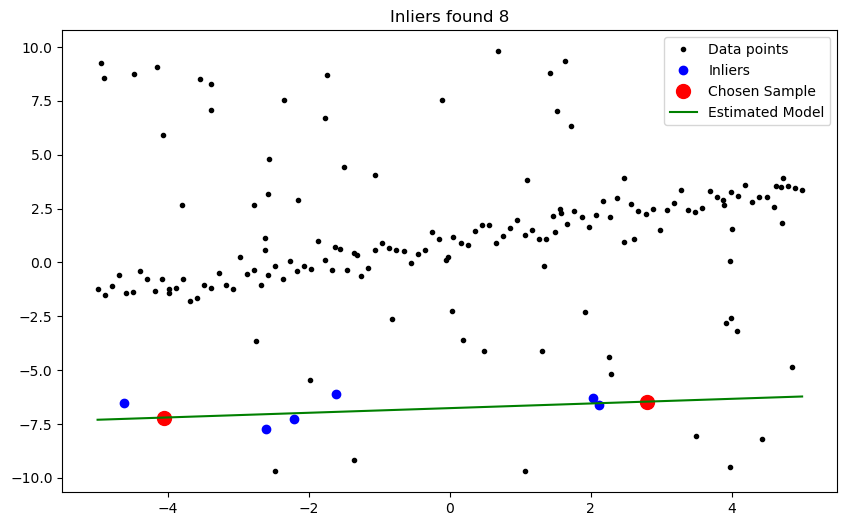

[array([-1.96969697, -0.28570179]), array([-1.76767677,  0.109413  ]), array([-1.66666667, -0.3621888 ]), array([-1.56565657,  0.62844417]), array([-1.62384829,  0.71549368]), array([-0.1054724 ,  7.54678707]), array([-2.75730691, -3.6615599 ]), array([-1.06902275,  4.04968168])]


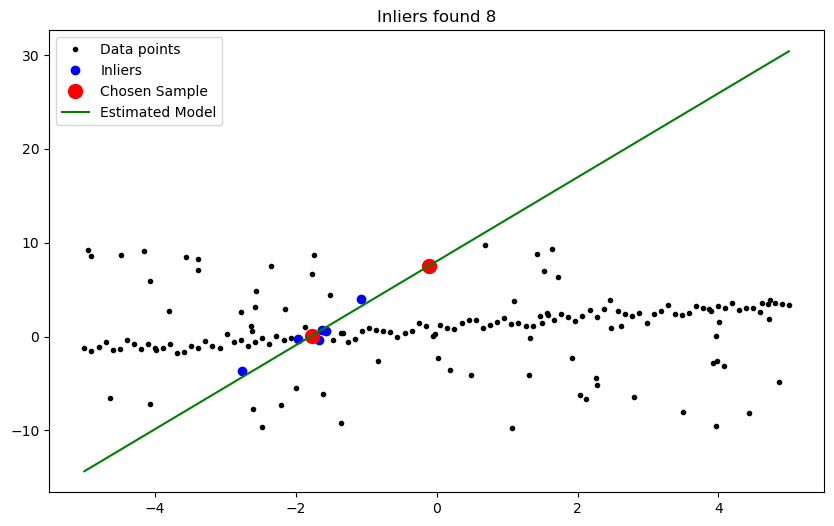

[array([0.65656566, 0.90867407]), array([0.75757576, 1.22418169]), array([0.85858586, 1.59492464]), array([0.95959596, 1.96757054]), array([1.06060606, 1.29071591]), array([1.16161616, 1.48797859]), array([1.26262626, 1.07814564]), array([1.36363636, 1.08371487]), array([1.46464646, 2.13858614]), array([1.56565657, 2.4609483 ]), array([1.66666667, 1.79732827]), array([1.76767677, 2.38560483]), array([1.86868687, 2.11516145]), array([2.17171717, 2.85487687]), array([2.37373737, 2.96919051]), array([-0.82588997, -2.64433735]), array([-1.9912169, -5.4700845]), array([2.46491405, 3.92059593]), array([1.49632899, 1.4012234 ]), array([1.57612892, 2.30014453])]


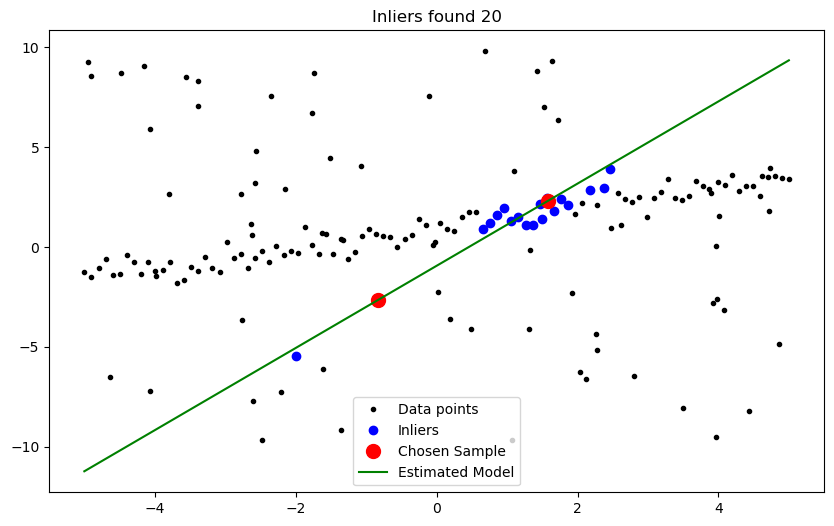

In [61]:
epochs = 10 
thres = 1.0 
min_inliers_to_stop = 80 
best_inliers = []


for epoch in range(epochs):
    #getting any 2 random data from the data stack 
    sample = data[np.random.choice(data.shape[0], 2)]
    x_sample, y_sample = sample[:, 0], sample[:, 1]
    A = np.vstack([x_sample, np.ones(len(x_sample))]).T
    m, b = np.linalg.lstsq(A, y_sample, rcond=None)[0]
    
    # Step 3: Compute inliers
    inliers = getInliers((m, b), data, thres)
    print(inliers)

    # Plotting
    plt.figure(figsize=(10, 6))

    # Plot all data points
    plt.plot(data[:, 0], data[:, 1], 'k.', label='Data points')

    # Highlight inliers
    inlier_array = np.array(inliers)
    if inlier_array.size > 0:
        plt.plot(inlier_array[:, 0], inlier_array[:, 1], 'bo', label='Inliers')

    # Highlight chosen sample
    plt.plot(x_sample, y_sample, 'ro', markersize=10, label='Chosen Sample')

    # Plot the estimated model
    x_range = np.linspace(min(data[:, 0]), max(data[:, 0]), 100)
    plt.plot(x_range, m * x_range + b, 'g-', label='Estimated Model')
    plt.title(f'Inliers found {len(inliers)}')
    plt.legend()
    plt.show()
    
# Update best model if current iteration is better
    if len(inliers) > len(best_inliers):
        best_inliers = inliers
        best_params = (m, b)
        
        # # Optional early stopping if enough inliers are found
        # if len(best_inliers) > min_inliers_to_stop:
        #     break
    
            
# Step 5: Re-estimate model parameters using all inliers if desired
if best_inliers:
    x_inliers, y_inliers = np.array(best_inliers).T
    A = np.vstack([x_inliers, np.ones(len(x_inliers))]).T
    m, b = np.linalg.lstsq(A, y_inliers, rcond=None)[0]
    best_params = (m, b)


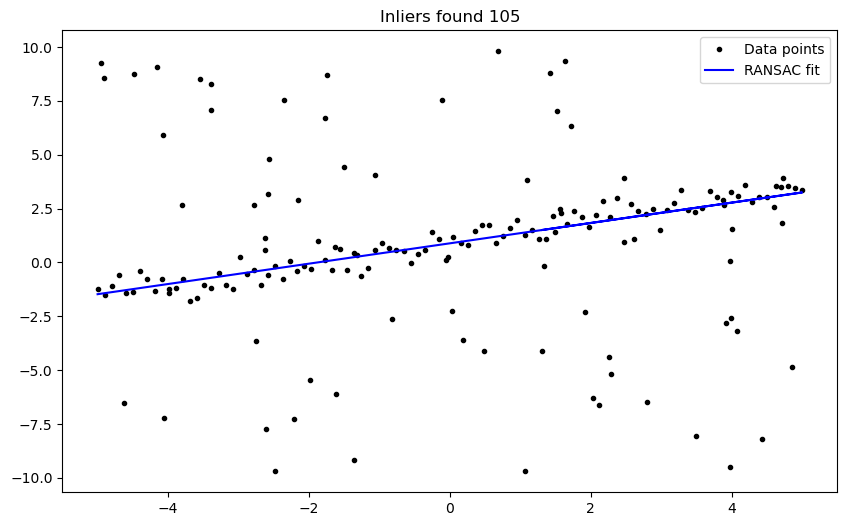

In [64]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'k.', label='Data points')
plt.plot(x, getY(best_params, x), 'b-', label='RANSAC fit')
plt.title(f'Inliers found {len(best_inliers)}')
plt.legend()
plt.show()